In [1]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split

In [3]:

eclipsing_binary_list = np.load("../dataset/light_curve_instance/eclipsing_binary/lc_eclipsing_binary.npy",
                                allow_pickle=True)
len(eclipsing_binary_list)

KeyboardInterrupt: 

In [ ]:
print(eclipsing_binary_list[0].meta)

In [ ]:
from tqdm import tqdm

full_lc_pd = pd.DataFrame(columns=eclipsing_binary_list[0].meta.keys())
for lc in tqdm(eclipsing_binary_list):
    full_lc_pd = full_lc_pd.append(lc.meta, ignore_index=True)
full_lc_pd

In [ ]:
full_lc_pd.to_csv("../dataset/light_curve_dataframe/eclipsing_binary/lc_eclipsing_binary.csv", index=False)

In [31]:
full_lc_pd = pd.read_csv("../dataset/light_curve_dataframe/eclipsing_binary/lc_eclipsing_binary.csv")

In [32]:
full_lc_pd.columns.tolist()

['source_id',
 'raj2000',
 'dej2000',
 'l',
 'b',
 'mean_vmag',
 'amplitude',
 'period',
 'variable_type',
 'class_probability',
 'lksl_statistic',
 'rfr_score',
 'epoch_hjd',
 'gdr2_id',
 'phot_g_mean_mag',
 'e_phot_g_mean_mag',
 'phot_bp_mean_mag',
 'e_phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'e_phot_rp_mean_mag',
 'bp_rp',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'vt',
 'dist',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'w1_mag',
 'e_w1_mag',
 'w2_mag',
 'e_w2_mag',
 'w3_mag',
 'e_w3_mag',
 'w4_mag',
 'e_w4_mag',
 'j_k',
 'w1_w2',
 'w3_w4',
 'apass_dr9_id',
 'apass_vmag',
 'e_apass_vmag',
 'apass_bmag',
 'e_apass_bmag',
 'apass_gpmag',
 'e_apass_gpmag',
 'apass_rpmag',
 'e_apass_rpmag',
 'apass_ipmag',
 'e_apass_ipmag',
 'b_v',
 'e_b_v',
 'vector_x',
 'vector_y',
 'vector_z',
 'periodic',
 'created_at',
 'updated_at',
 'nuvmag',
 'e_nuvmag',
 'pm',
 'ruwe',
 'main_type',
 'mean',
 'median',
 's

In [33]:
# full_lc_pd_ell = full_lc_pd[full_lc_pd["variable_type"]=="ELL"]
# full_lc_pd = full_lc_pd[full_lc_pd["variable_type"]!="ELL"][:10000]
# full_lc_pd = full_lc_pd.append(full_lc_pd_ell)

In [38]:
full_lc_pd = full_lc_pd[(full_lc_pd["class_probability"] >= 0.20) | (full_lc_pd["class_probability"] is None)]
sub_class = full_lc_pd["variable_type"]
# features_drop_unlabel = full_lc_pd[useful_feature_cepheids1]
features_drop_unlabel = full_lc_pd.drop(
    labels=["source_id", "class_probability", "variable_type", "created_at", "main_type", "updated_at", "raj2000",
            "dej2000", "mean_vmag", "lksl_statistic", "rfr_score", "epoch_hjd", "e_b_v", "vector_x", "vector_y",
            "vector_z", "periodic", "l", "b"], axis=1)
features_drop_unlabel = features_drop_unlabel.dropna(axis=1)
features_drop_unlabel

,amplitude,period,mean,median,std,skewness,kurtosis,shapiro_w,IQR,p2p,...,b54,depth_ratio,slope_diff_ratio,similarity,phase_eta,slope_per10,slope_per90,slope_per20,slope_per80,phase_cusum
0,0.43,0.369614,14.247599,14.202,0.142713,0.500412,-1.145314,0.904199,0.26200,0.487,...,0.016009,0.000000,1.107516,0.987844,0.069590,-0.107168,0.105149,-0.044136,0.048258,0.272312
1,0.21,1.992654,12.382639,12.412,0.070507,-0.396765,-1.408323,0.877730,0.12950,0.232,...,0.725250,0.012931,1.211936,0.966092,0.539229,-1.484450,1.349271,-0.698874,0.537312,0.197429
2,0.21,1.992654,12.410763,12.412,0.059859,0.434794,-0.129593,0.966451,0.08200,0.263,...,-0.414279,0.003802,2.353940,0.975938,0.887772,-0.592608,0.904362,-0.251150,0.370921,0.216416
3,0.36,0.412779,13.185738,13.140,0.113869,0.724848,-0.915747,0.864701,0.19300,0.368,...,-0.068455,0.021739,1.109102,0.983095,0.046302,-0.298712,0.267680,-0.161734,0.096642,0.250773
4,0.36,0.412779,13.175300,13.140,0.116021,0.524846,-1.084964,0.902068,0.20800,0.396,...,-0.010638,0.002525,1.348041,0.982628,0.089193,-0.203587,0.226081,-0.098112,0.109488,0.230508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127334,0.13,0.468586,13.668373,13.663,0.038960,0.217261,-0.895774,0.970155,0.06075,0.163,...,0.659398,0.042945,1.085785,0.956323,0.715128,-0.353347,0.371974,-0.169320,0.148949,0.211349
127335,0.50,5.021012,13.436705,13.413,0.084740,4.134982,19.600252,0.471157,0.02050,0.597,...,1.192759,0.556114,6.169001,0.950807,0.844292,-11.960270,10.664640,-4.298160,3.294531,0.161760
127336,0.50,5.021012,13.439635,13.413,0.099210,3.254838,10.122744,0.490252,0.02125,0.551,...,0.591638,0.284936,1.264316,0.939473,0.293483,-4.076498,3.908200,-1.559490,1.362397,0.165524
127337,0.17,0.402175,14.162061,14.165,0.052464,-0.011596,-1.192687,0.957627,0.08950,0.193,...,-2.461598,0.010363,1.115968,0.971849,0.374355,-0.173481,0.144664,-0.080845,0.057095,0.234512


In [39]:
feature_set10 = ["r42", "r21", "b42", "period", "r32", "kurtosis", "skewness", "b2", "b1", "depth_ratio"]
feature_set15 = ["r42", "r21", "b42", "period", "r32", "kurtosis", "skewness", "b2", "b1", "depth_ratio", "Mm_ratio",
               "b32", "similarity", "shapiro_w", "phase_eta"]
feature_set20 = ["r42", "r21", "b42", "period", "r32", "kurtosis", "skewness", "b2", "b1", "depth_ratio", "Mm_ratio",
               "b32", "similarity", "shapiro_w", "phase_eta","slope_per10","r41","hl_amp_ratio","stetson_k","phase_cusum"]
feature_set25 = ["r42", "r21", "b42", "period", "r32", "kurtosis", "skewness", "b2", "b1", "depth_ratio", "Mm_ratio",
               "b32", "similarity", "shapiro_w", "phase_eta","slope_per10","r41","hl_amp_ratio","stetson_k","phase_cusum","slope_per80","slope_per20","b43","b21","r43"]
feature_set30 = ["r42", "r21", "b42", "period", "r32", "kurtosis", "skewness", "b2", "b1", "depth_ratio", "Mm_ratio",
                 "b32", "similarity", "shapiro_w", "phase_eta", "slope_per10", "r41", "hl_amp_ratio", "stetson_k",
                 "phase_cusum", "slope_per80", "slope_per20", "b43", "b21", "r43", "slope_per90", "b3",
                 "slope_diff_ratio", "a54", "b31"]
kim_feature = ['period', 'skewness', 'kurtosis', 'shapiro_w', 'IQR',
                       'stetson_k', 'hl_amp_ratio', 'h_1', 'r21', 'r31', 'phi21',
                       'phi31', 'phase_eta', 'slope_per10', 'slope_per90', 'phase_cusum']
features_drop_unlabel = features_drop_unlabel[feature_set25]

In [40]:
label_encoder = LabelEncoder()
sub_class = label_encoder.fit_transform(sub_class)
sub_class = sub_class.astype(np.int32)

In [41]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features_drop_unlabel, sub_class, test_size=0.2, shuffle=True,
                                                    random_state=0)
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# X_train, y_train = ADASYN().fit_resample(X_train, y_train)
# X_train, y_train = SVMSMOTE().fit_resample(X_train, y_train)
# X_train, y_train = SVMSMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0, 31319), (1, 15904), (2, 60), (3, 54578)]


In [42]:
param_grid = [
    {'max_features': range(90, 101, 10)},
    # {'bootstrap': [False], 'n_estimators': (50,100), 'max_features': range(10, 101, 10)}
]
clf = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START max_features=90.............................................
[CV 1/5; 1/2] END max_features=90;, score=(train=1.000, test=0.937) total time=  45.5s
[CV 2/5; 1/2] START max_features=90.............................................
[CV 2/5; 1/2] END max_features=90;, score=(train=1.000, test=0.939) total time=  34.6s
[CV 3/5; 1/2] START max_features=90.............................................
[CV 3/5; 1/2] END max_features=90;, score=(train=1.000, test=0.938) total time=  34.8s
[CV 4/5; 1/2] START max_features=90.............................................
[CV 4/5; 1/2] END max_features=90;, score=(train=1.000, test=0.936) total time=  34.5s
[CV 5/5; 1/2] START max_features=90.............................................
[CV 5/5; 1/2] END max_features=90;, score=(train=1.000, test=0.939) total time=  32.9s
[CV 1/5; 2/2] START max_features=100............................................
[CV 1/5; 2/2] END m

In [43]:
grid_search.score(X_test, y_test)

0.9394486766669284

In [26]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9179354305168201 {'max_features': 90}
0.917798017321487 {'max_features': 100}


In [27]:
# 计算每种特征对分类结果的影响
feature_name = features_drop_unlabel.columns
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, feature_name), reverse=True)

[(0.4618060196020226, 'kurtosis'),
 (0.14556849200016816, 'r21'),
 (0.12955198111648364, 'period'),
 (0.049424780998725514, 'phase_cusum'),
 (0.029876953241494815, 'phase_eta'),
 (0.029575196153901796, 'r31'),
 (0.026388223545815957, 'skewness'),
 (0.015730920624922377, 'shapiro_w'),
 (0.015643442827893567, 'stetson_k'),
 (0.015589838946655148, 'h_1'),
 (0.014655442341083983, 'IQR'),
 (0.014312899070541696, 'hl_amp_ratio'),
 (0.0134705571474675, 'phi21'),
 (0.013183474596889774, 'slope_per90'),
 (0.012913464449779609, 'slope_per10'),
 (0.012308313336153903, 'phi31')]

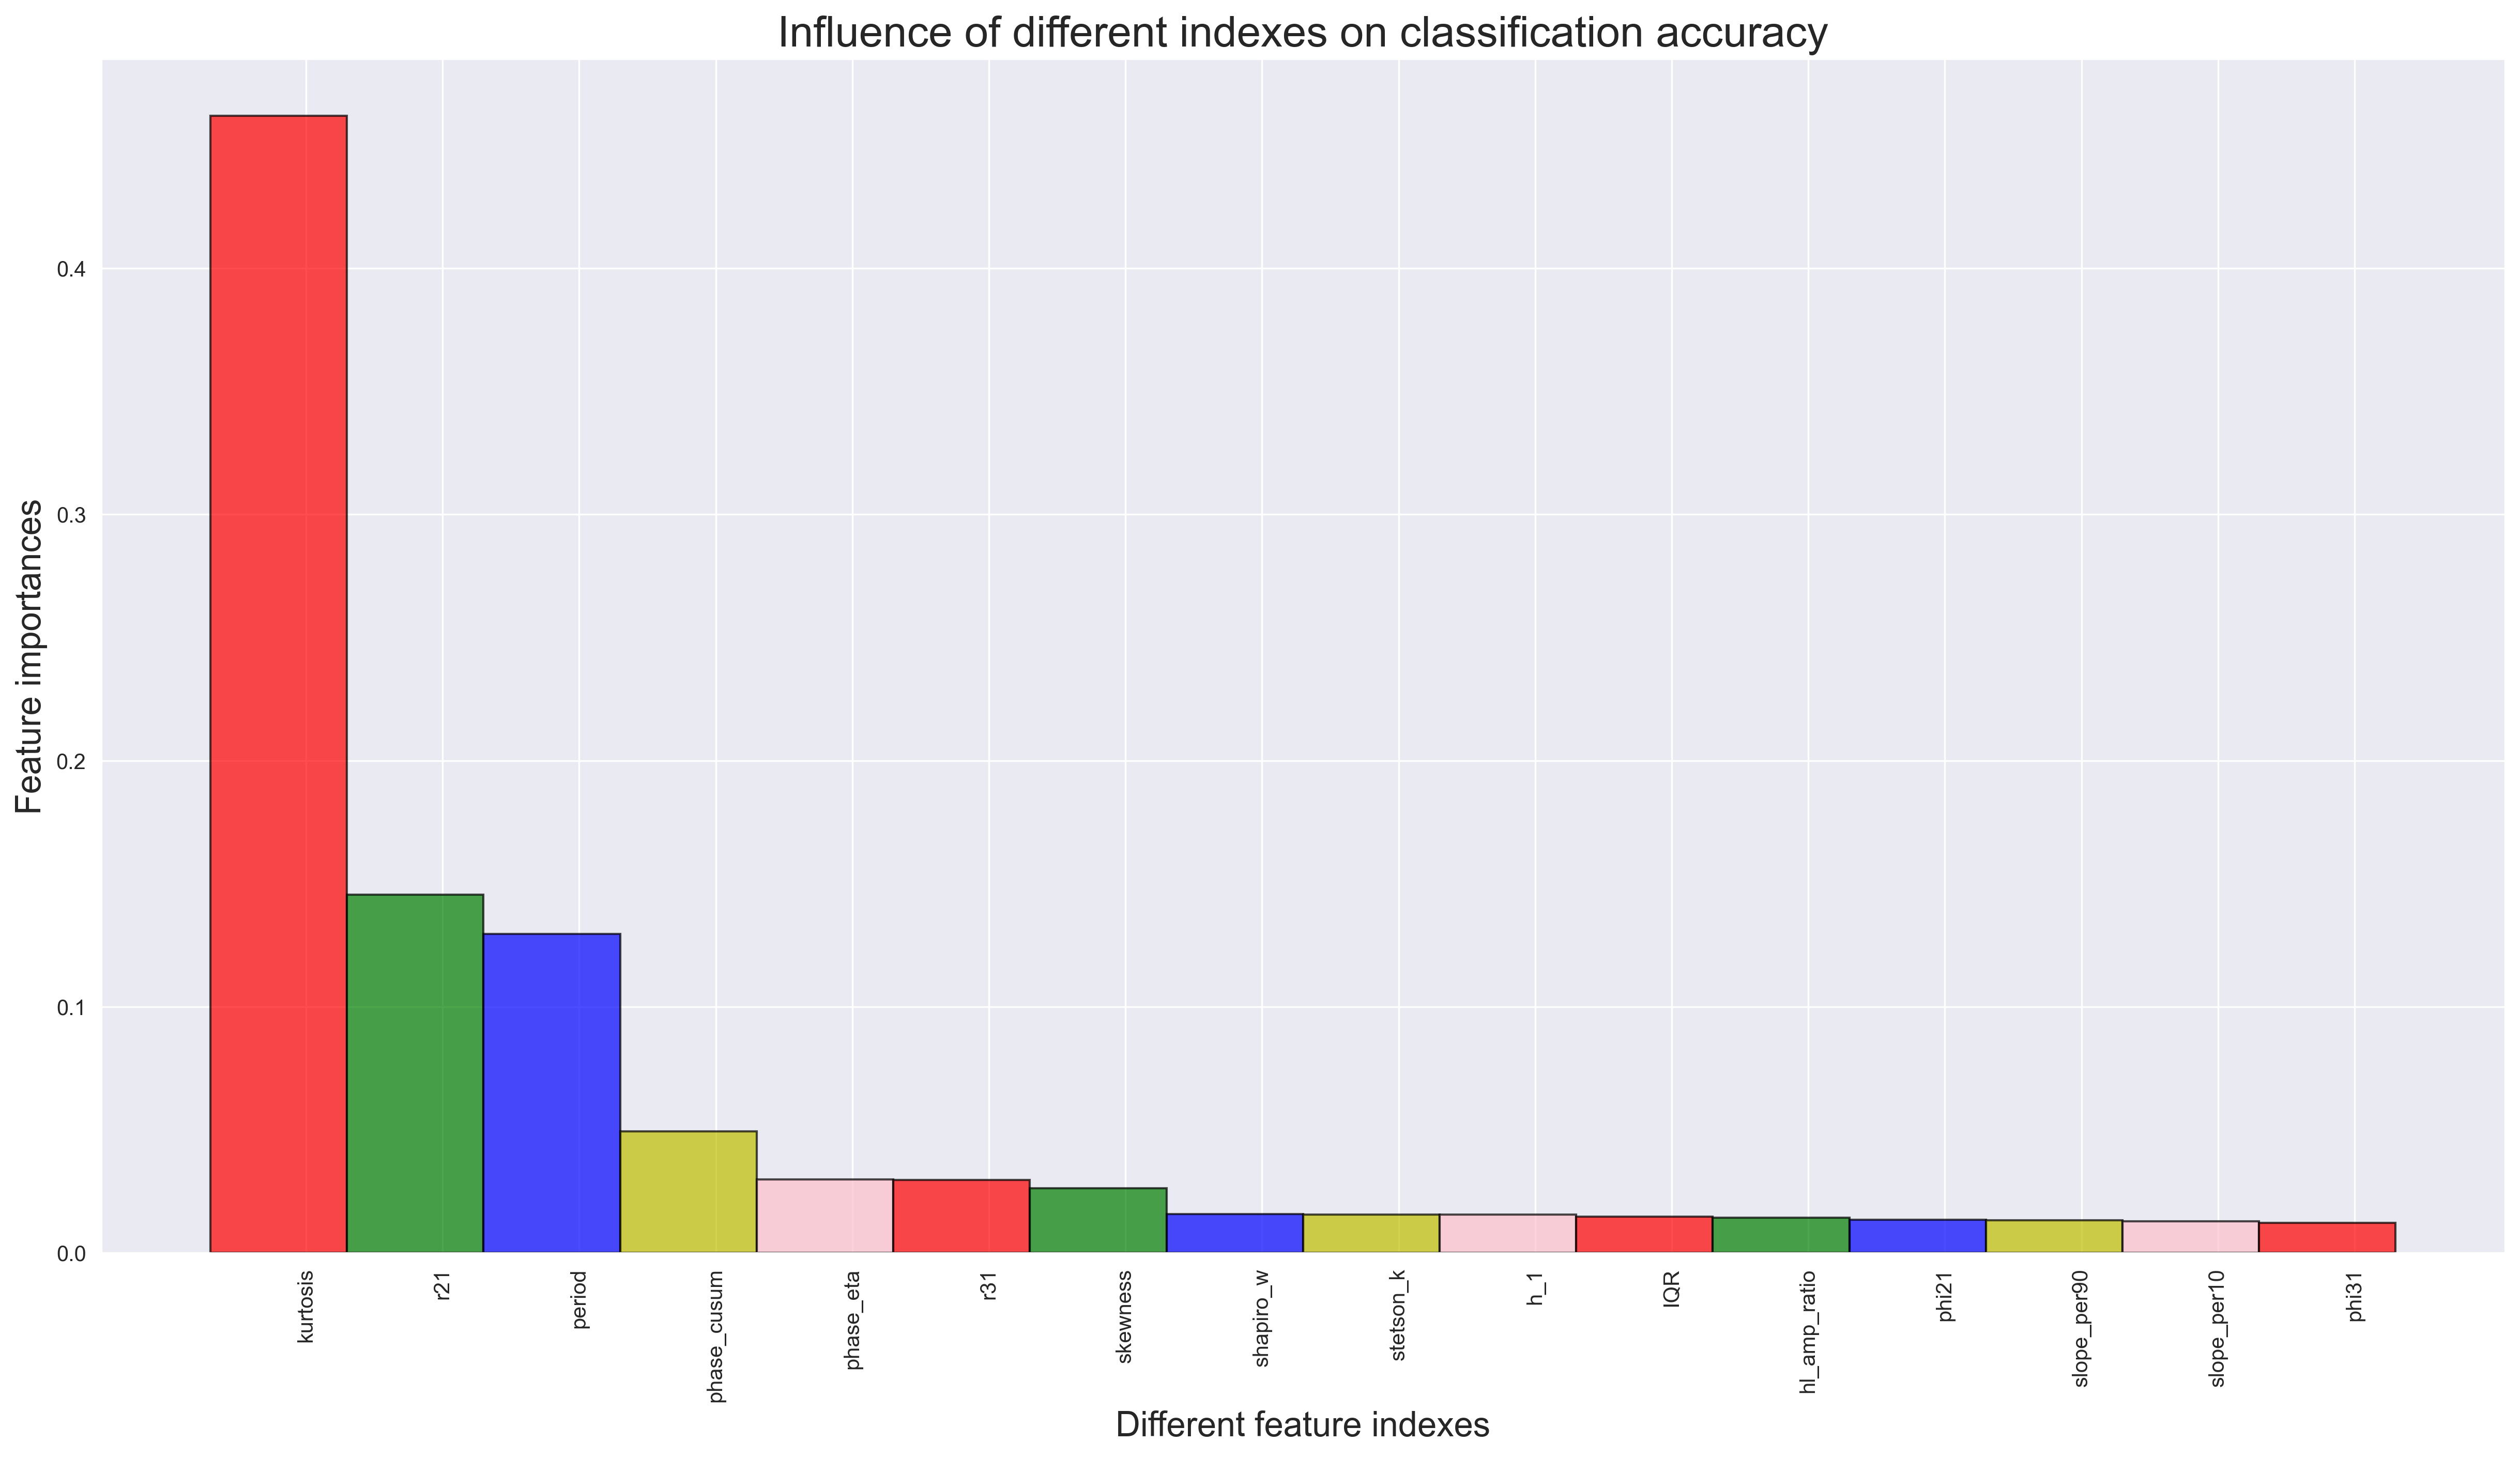

FileNotFoundError: [Errno 2] No such file or directory: './output/feature_important/random_forest_cepheids_importance_0.9179354305168201.png'

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

importances = sorted(zip(feature_importances, feature_name), reverse=True)
feature_im = []
feature_n = []
for i in importances:
    feature_im.append(i[0])
    feature_n.append(i[1])
plt.figure(figsize=(20, 10), dpi=300)
indexes = np.arange(len(feature_im))
plt.title("Influence of different indexes on classification accuracy", fontsize=20)
plt.xlabel("Different feature indexes", fontsize=16)
plt.ylabel("Feature importances", fontsize=16)
plt.bar(2 * indexes, feature_im, 2, edgecolor="black", alpha=0.7, color=['r', 'g', 'b', 'y', 'pink'])
plt.xticks(2 * indexes + 2 * 0.2, feature_n, rotation=90)
plt.show()
plt.savefig(f"./output/feature_important/random_forest_cepheids_importance_{grid_search.best_score_}.png")

([<matplotlib.axis.YTick at 0x232170b0ca0>,
 [Text(0, 0, 'EA'), Text(0, 1, 'EB'), Text(0, 2, 'ELL'), Text(0, 3, 'EW')])

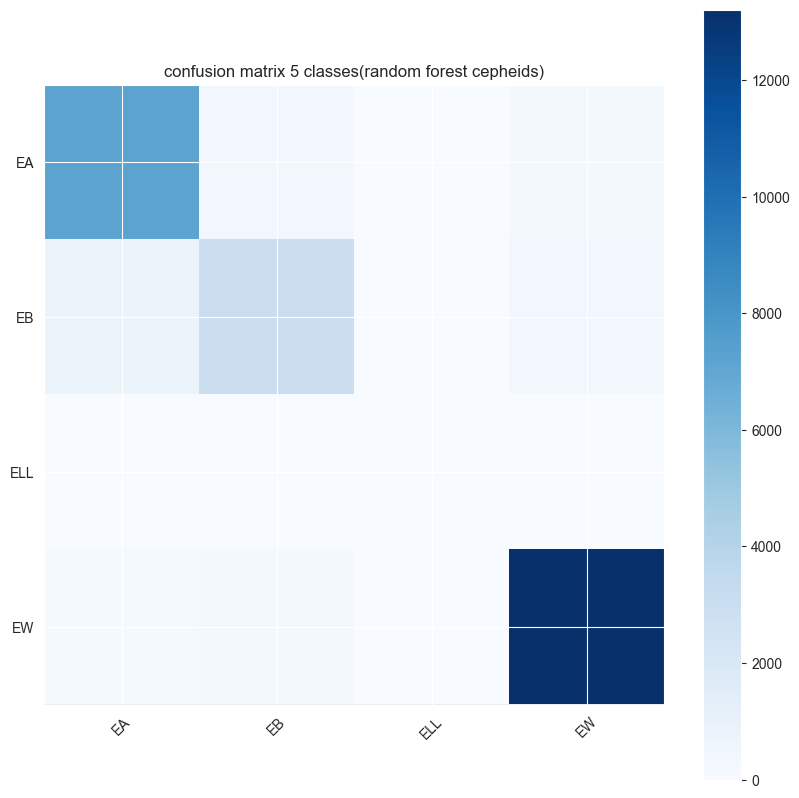

In [29]:
# from my_util.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(np.concatenate([np.array(y_test), np.array(y_pred)]))
classes = label_encoder.inverse_transform(classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion matrix 5 classes(random forest cepheids)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

In [30]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

# print(recall_score(y_test, y_pred, average='macro'))
# print(f1_score(y_test, y_pred, average='macro'))
# print(precision_score(y_test, y_pred, average='macro'))
# print(recall_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=["EA", "EB", "ELL", "EW"], digits=4))

              precision    recall  f1-score   support

          EA     0.8953    0.9216    0.9083      7809
          EB     0.8196    0.7322    0.7735      3996
         ELL     0.8000    0.2353    0.3636        17
          EW     0.9535    0.9680    0.9607     13646

    accuracy                         0.9163     25468
   macro avg     0.8671    0.7143    0.7515     25468
weighted avg     0.9145    0.9163    0.9149     25468



In [97]:
joblib.dump(label_encoder, f"./output/label_encoder/cepheids_label_{grid_search.best_score_}.pkl")

FileNotFoundError: [Errno 2] No such file or directory: './output/label_encoder/cepheids_label_0.9873653937708639.pkl'